<a href="https://colab.research.google.com/github/Oaybarf/FX/blob/main/Estrategia_USDPEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración e Instalaciones

In [3]:
%%capture
# Instalar otros paquetes
!pip install tabulate
!pip install statsmodels


url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

# Corrida Completa
  Candlestick patterns, Relative Strength Index (RSI), Bollinger Bands, and Moving Average Convergence Divergence (MACD).

## Descargando Información y Calculando Indicadores

### Importaciones

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import talib as ta
from talib import MA_Type
from tabulate import tabulate
import matplotlib.pyplot as plt
import datetime as dt
import plotly.io as pio

### Download Data

In [5]:
stock_symbol = 'PEN=X' # USD
# stock_symbol = 'VSAT' # VIASAT

stock_data = yf.download(stock_symbol,  period="max")

# Create a Date column
stock_data['Date'] = stock_data.index
# Drop the Date as index
stock_data.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed


### Clean Data

In [6]:
dt_all = pd.date_range(start=stock_data.index[0],end=stock_data.index[-1])

dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data.index)]

dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

### Cálculos Indicadores Técnicos

In [7]:
# 1. EMA 10, 20, 50
# --------------------------------------------
stock_data['EMA10'] = stock_data['Close'].ewm(span=10, min_periods=10, adjust=False).mean()
stock_data['EMA20'] = stock_data['Close'].ewm(span=20, min_periods=20, adjust=False).mean()
stock_data['EMA50'] = stock_data['Close'].ewm(span=50, min_periods=50, adjust=False).mean()
stock_data['EMA100'] = stock_data['Close'].ewm(span=100, min_periods=100, adjust=False).mean()
stock_data['EMA200'] = stock_data['Close'].ewm(span=200, min_periods=200, adjust=False).mean()

# 2. MACD values
# --------------------------------------------
stock_data['macd'], stock_data['macdSignal'], stock_data['macdHist'] = ta.MACD(stock_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['macddiff1'] = stock_data['macd'].shift(1) - stock_data['macdSignal'].shift(1)
stock_data['macddiff-1'] = stock_data['macd'].shift(-1) - stock_data['macdSignal'].shift(-1)

# 3. RSI
# --------------------------------------------
stock_data['RSI'] = ta.RSI(stock_data.Close, 14)


# 4. Bollinger Bands
# --------------------------------------------
stock_data['BU'], stock_data['BM'], stock_data['BL'] = ta.BBANDS(stock_data.Close,
                                                                 timeperiod=20,
                                                                 matype=MA_Type.EMA)
# 5. Buy and Sell Signals
# --------------------------------------------
# Drop Buy and Sell columns if they exist
stock_data.drop(['Buy', 'Sell'], inplace=True, axis=1, errors='ignore')

# Create DataFrame
df_buy = stock_data.query('Low < BL')[['Date', 'Close']]
df_sell = stock_data.query('High > BU')[['Date', 'Close']]

# Round close values for both buy and sell
# df_buy['Close'] = round(df_buy.Close.round())
# df_sell['Close'] = round(df_sell.Close.round())

# 5. ATR
# --------------------------------------------
stock_data['ATR'] = ta.ATR(stock_data['High'], stock_data['Low'], stock_data['Close'], timeperiod=14)
stock_data['ATR_SMA_1year'] = stock_data['ATR'].rolling(window=252).mean()

### Recomendaciones

In [8]:
stock_data['EMA10_Recommendation'] = 0
stock_data['EMA20_Recommendation'] = 0
stock_data['EMA50_Recommendation'] = 0
stock_data['EMA100_Recommendation'] = 0
stock_data['EMA200_Recommendation'] = 0
stock_data['MACD_Recommendation'] = 0
stock_data['RSI_Recommendation'] = 0
stock_data['BB_Recommendation'] = 0
stock_data['ATR_Recommendation'] = 0
stock_data['Final_Recommendation'] = 0


stock_data.loc[stock_data['RSI'] > 70, 'RSI_Recommendation'] = -1  # Venta para RSI sobrecomprado
stock_data.loc[stock_data['RSI'] < 30, 'RSI_Recommendation'] = 1   # Compra para RSI sobrevendido

stock_data.loc[stock_data['Close'] > stock_data['BU'], 'BB_Recommendation'] = -1  # Venta para precios por encima de la banda superior de Bollinger
stock_data.loc[stock_data['Close'] < stock_data['BL'], 'BB_Recommendation'] = 1   # Compra para precios por debajo de la banda inferior de Bollinger

# Recomendación de compra cuando la diferencia cruza de negativa a positiva (cruce hacia arriba)
stock_data.loc[(stock_data['macd'] > stock_data['macdSignal']) & (stock_data['macd'].shift(1) <= stock_data['macdSignal'].shift(1)), 'MACD_Recommendation'] = -1
stock_data.loc[(stock_data['macd'] < stock_data['macdSignal']) & (stock_data['macd'].shift(1) >= stock_data['macdSignal'].shift(1)), 'MACD_Recommendation'] = 1


emas = ['EMA10', 'EMA20', 'EMA50', 'EMA100', 'EMA200']
for ema in emas:
    stock_data.loc[(stock_data[ema] > stock_data['Close']) & (stock_data[ema].shift(1) <= stock_data['Close'].shift(1)), f'{ema}_Recommendation'] = 1
    stock_data.loc[(stock_data[ema] < stock_data['Close']) & (stock_data[ema].shift(1) >= stock_data['Close'].shift(1)), f'{ema}_Recommendation'] = -1


stock_data.loc[(stock_data['ATR'] > stock_data['ATR_SMA_1year']) & (stock_data['ATR'].shift(1) <= stock_data['ATR_SMA_1year'].shift(1)), 'ATR_Recommendation'] = 1
stock_data.loc[(stock_data['ATR'] < stock_data['ATR_SMA_1year']) & (stock_data['ATR'].shift(1) >= stock_data['ATR_SMA_1year'].shift(1)), 'ATR_Recommendation'] = -1


stock_data['Promedio_Recomendaciones'] = (stock_data['EMA10_Recommendation'] * 0.10 +
                                          stock_data['EMA20_Recommendation'] * 0.10 +
                                          stock_data['EMA50_Recommendation'] * 0.10 +
                                          stock_data['MACD_Recommendation'] * 0.20 +
                                          stock_data['RSI_Recommendation'] * 0.25 +
                                          stock_data['BB_Recommendation'] * 0.25)

stock_data['Final_Recommendation'] = round(stock_data['Promedio_Recomendaciones'])+0.0

### BackTesting

In [9]:
# Calcular el cambio en el precio del siguiente mes
stock_data['Next_Month_Close'] = stock_data['Close'].shift(-20)  # Suponiendo que cada mes tiene 20 días hábiles

# Calcular el cambio en el precio
stock_data['Price_Change'] = (stock_data['Next_Month_Close'] / stock_data['Close'] -1)

# Calcular la rentabilidad de cada estrategia
strategies = ['EMA10_Recommendation', 'EMA20_Recommendation', 'EMA50_Recommendation', 'EMA100_Recommendation', 'EMA200_Recommendation',
              'MACD_Recommendation', 'RSI_Recommendation', 'BB_Recommendation', 'ATR_Recommendation','Final_Recommendation']

for strategy in strategies:
    stock_data[strategy + '_Profit'] = stock_data[strategy] * stock_data['Price_Change']


In [10]:
# Inicializar un diccionario para almacenar los resultados por estrategia
summary_by_year = {}

# Iterar sobre cada año
for year in stock_data['Date'].dt.year.unique():
    # Filtrar los datos para el año actual y eliminar las rentabilidades iguales a 0
    year_data = stock_data[stock_data['Date'].dt.year == year]

    # Inicializar un diccionario para almacenar las rentabilidades medias por estrategia
    yearly_mean_profit = {}

    # Calcular la media de todas las rentabilidades para el año actual por cada estrategia
    for strategy in strategies:
        yearly_mean_profit[strategy + '_Profit'] = year_data[year_data[strategy + '_Profit'] != 0][strategy + '_Profit'].count()

    # Agregar los resultados al diccionario
    summary_by_year[year] = yearly_mean_profit

# Crear un DataFrame a partir del diccionario
summary_df = pd.DataFrame(summary_by_year).transpose()

# Mostrar el resumen
# summary_df

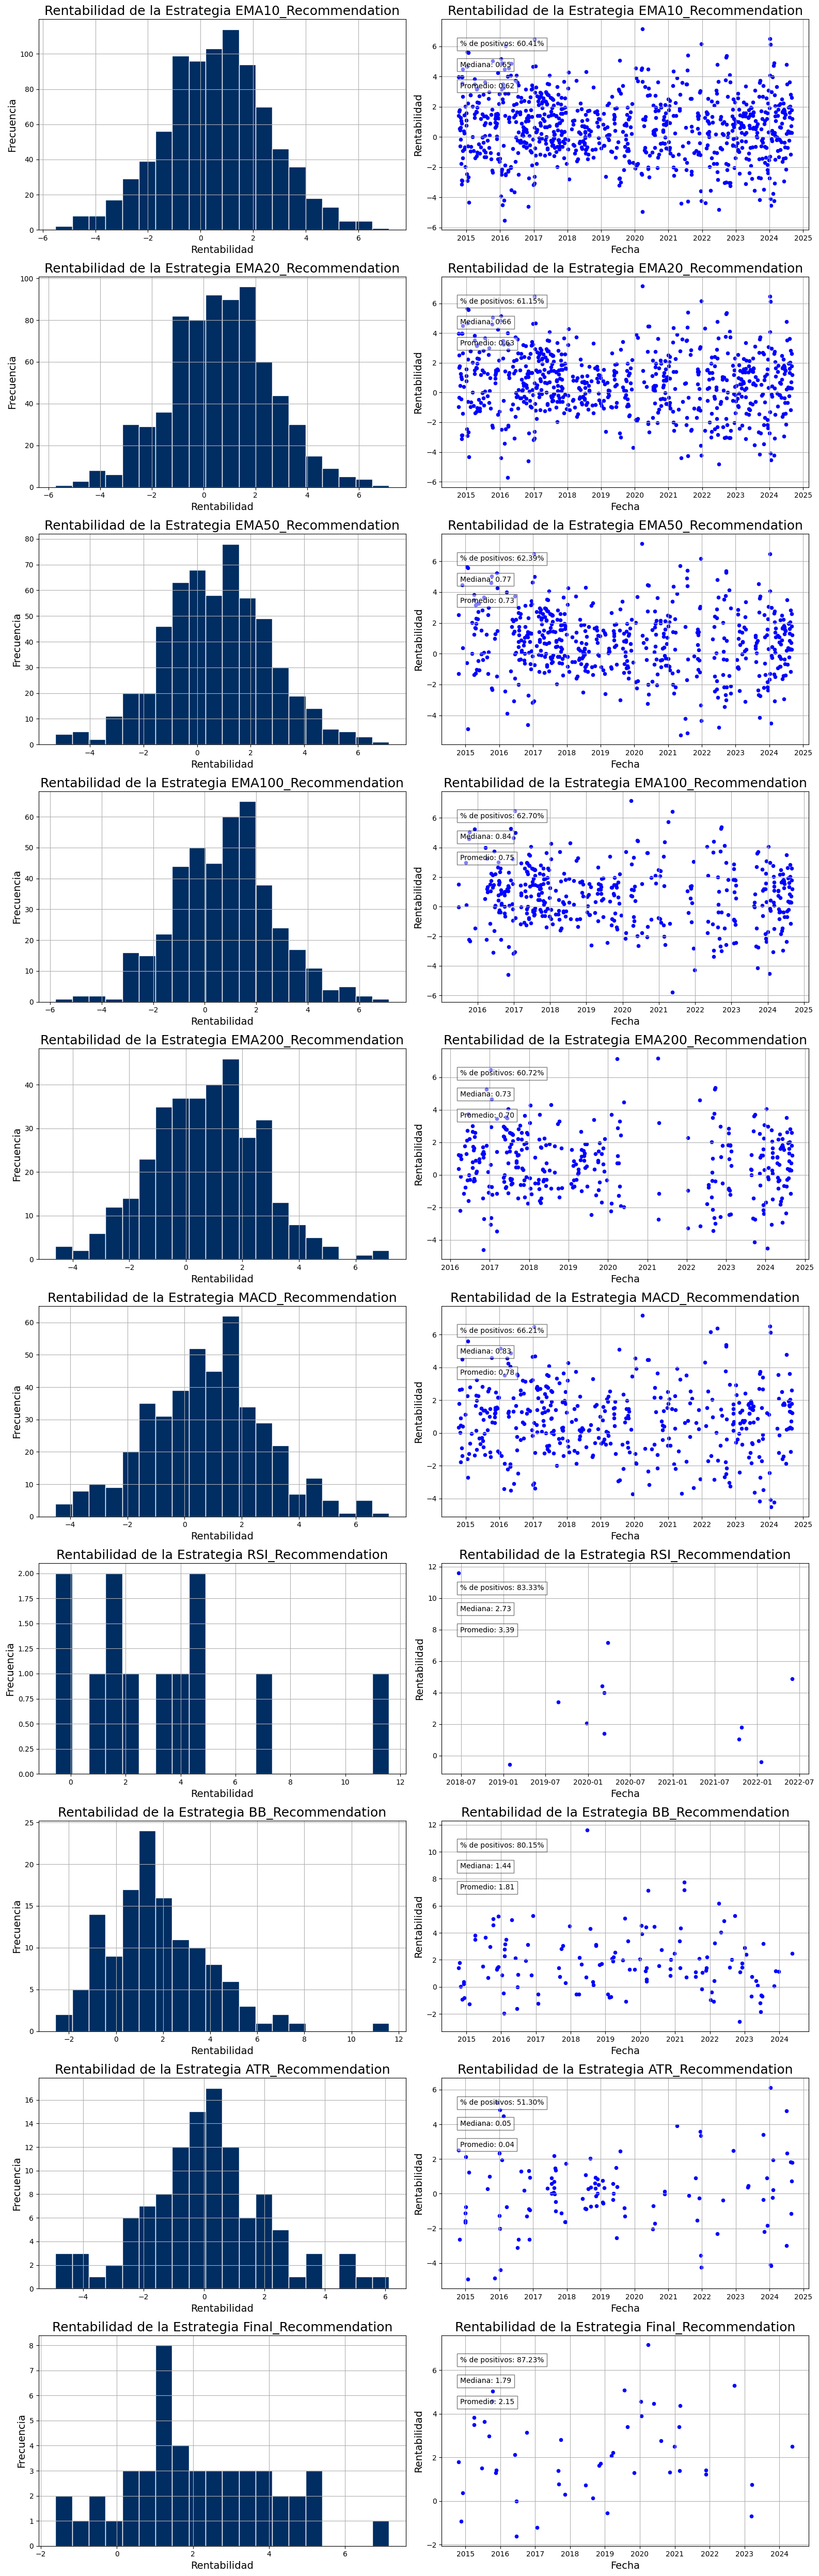

In [11]:
# Crear subplots con histogramas y gráficos de líneas
plt.style.use('default')
fig, axs = plt.subplots(len(strategies), 2, figsize=(16, 5*len(strategies)))
years_ago = dt.datetime.now() - dt.timedelta(days=10*365)
color_is = (0, 0.176, 0.384)

for i, strategy in enumerate(strategies):
    # Filtrar las filas donde la recomendación no sea aproximadamente 0
    filtered_data = stock_data[(stock_data[strategy] != 0) & (stock_data['Date'] > years_ago)]

    # Histograma
    axs[i, 0].hist(filtered_data[strategy + '_Profit'] * 100, bins=20, color=color_is, edgecolor='white')
    axs[i, 0].set_title(f'Rentabilidad de la Estrategia {strategy}', fontsize=18)
    axs[i, 0].set_xlabel('Rentabilidad', fontsize=14)
    axs[i, 0].set_ylabel('Frecuencia', fontsize=14)
    axs[i, 0].grid(True)

    # Gráfico de puntos
    axs[i, 1].scatter(filtered_data['Date'], filtered_data[strategy + '_Profit'] * 100, color='blue', s=20)
    axs[i, 1].set_title(f'Rentabilidad de la Estrategia {strategy}', fontsize=18)
    axs[i, 1].set_xlabel('Fecha', fontsize=14)
    axs[i, 1].set_ylabel('Rentabilidad', fontsize=14)
    axs[i, 1].grid(True)

    # Calcular el porcentaje de rentabilidades positivas
    positive_percentage = (filtered_data[strategy + '_Profit'] > 0).mean() * 100

    # Calcular la mediana y el promedio de rentabilidad
    median_profit = filtered_data[strategy + '_Profit'].median()*100
    mean_profit = filtered_data[strategy + '_Profit'].mean()*100

    # Mostrar el porcentaje de positivos, la mediana y el promedio en el gráfico
    axs[i, 1].text(0.05, 0.9, f'% de positivos: {positive_percentage:.2f}%', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(0.05, 0.8, f'Mediana: {median_profit:.2f}', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(0.05, 0.7, f'Promedio: {mean_profit:.2f}', transform=axs[i, 1].transAxes,
                   verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

stock_data.to_csv('stock_data.csv', index=False)

In [12]:
# Establecer la configuración de la fuente
pio.templates.default = "plotly_white"
font_comite = "Montserrat"
color_comite = "rgb(0, 45, 98)"
color_positivo = "blue"
color_negativo = "rgb(255, 0, 0)" # Rojo para los valores negativos

# Estrategia seleccionada (cambiar según necesidad)
selected_strategy = strategies[1]

print(f'Rentabilidad de la Estrategia {selected_strategy}')

# Filtrar los datos para la estrategia seleccionada
filtered_data = stock_data[(stock_data[selected_strategy] != 0) & (stock_data['Date'] > years_ago)]

# Crear subplots con histograma y gráfico de puntos, ajustando las proporciones de las columnas
fig = make_subplots(rows=2, cols=1, row_heights=[0.5, 0.5])

# Histograma
hist_fig = go.Histogram(x=filtered_data[selected_strategy + '_Profit'] * 100, nbinsx=20, marker=dict(color=color_comite, line=dict(color='white', width=1)), showlegend=True, name='Histograma')
fig.add_trace(hist_fig, row=1, col=1)
fig.update_xaxes(row=1, col=1, tickfont=dict(color=color_comite, family=font_comite), showline=True, linecolor=color_comite, linewidth=0.5)
#fig.update_xaxes(title_text='<b>Rentabilidad (%)</b>', row=1, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite), showline=True, linecolor=color_comite, linewidth=0.5)
fig.update_yaxes(title_text='<b>Frecuencia</b>', row=1, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite))

# Gráfico de puntos
colors_scatter = [color_positivo if y >= 0 else color_negativo for y in filtered_data[selected_strategy + '_Profit'] * 100]

scatter_fig = go.Scatter(x=filtered_data['Date'], y=filtered_data[selected_strategy + '_Profit'] * 100, mode='markers', marker=dict(color= colors_scatter, size=6, opacity=0.5), showlegend=True, name='Gráfico de Puntos')
fig.add_trace(scatter_fig, row=2, col=1)
fig.update_xaxes(row=2, col=1, range=[years_ago, filtered_data['Date'].max()], tickfont=dict(color=color_comite, family=font_comite), showgrid=False, showline=True, linecolor=color_comite, linewidth=0.5)
# fig.update_xaxes(title_text='<b>Fecha</b>', row=2, col=1, range=[years_ago, filtered_data['Date'].max()], title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite), showgrid=False, showline=True, linecolor=color_comite, linewidth=0.5)
fig.update_yaxes(title_text='<b>Rentabilidad (%)</b>', row=2, col=1, title_font=dict(color=color_comite, family=font_comite), tickfont=dict(color=color_comite, family=font_comite))

# Calcular el porcentaje de rentabilidades positivas, la mediana y el promedio de rentabilidad
positive_percentage = (filtered_data[selected_strategy + '_Profit'] > 0).mean() * 100
median_profit = filtered_data[selected_strategy + '_Profit'].median() * 100
mean_profit = filtered_data[selected_strategy + '_Profit'].mean() * 100

# Actualizar el diseño del gráfico
fig.update_layout(
    font=dict(family=font_comite, color=color_comite),
    height=700,
    width=600,
    showlegend=False
)

# Mostrar el gráfico
fig.show()


Rentabilidad de la Estrategia EMA20_Recommendation


In [13]:
# Crear los datos de la tabla
table_data = {
    'Métrica': ['% de positivos', 'Mediana', 'Promedio'],
    'Valor': [f'{positive_percentage:.2f}%', f'{median_profit:.2f}', f'{mean_profit:.2f}']
}

# Crear la tabla
table_fig = go.Figure(data=[go.Table(
    header=dict(values=['<b>Métrica</b>', '<b>Valor</b>'],
                fill_color=color_comite,
                font=dict(color='white', family=font_comite),
                align='center'),
    cells=dict(values=[table_data['Métrica'], table_data['Valor']],
               fill_color='white',
               font=dict(color=color_comite, family=font_comite),
               align='center',
               line_color=color_comite)  # Añadir color de los bordes a las celdas
)])

# Actualizar el diseño de la tabla
table_fig.update_layout(
    width=500,
    height=300,
    margin=dict(l=10, r=10, t=10, b=10)
)

# Centrar la tabla en la figura
table_fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    plot_bgcolor='rgba(0,0,0,0)',  # Hacer el fondo del gráfico transparente
)

# Mostrar la tabla
table_fig.show()


### Buy and Sell signals

In [14]:
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                     high=stock_data['High'],
                                     low=stock_data['Low'],
                                      close=stock_data['Close'],
                                      name='Candlestick')])

# Add Bollinger Bands
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BU'],
                         mode='lines', name='Upper Band', line=dict(color='gray', dash='dash')))

fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BL'],
                         mode='lines', name='Lower Band', line=dict(color='gray', dash='dash')))


recomendaciones_grafico = 'BB_Recommendation'
buy_points = stock_data[stock_data[recomendaciones_grafico] == 1]
fig.add_trace(go.Scatter(x=buy_points['Date'], y=buy_points['Close'], mode='markers',
                         marker=dict(symbol='diamond', size=10, line=dict(width=1)), marker_color='yellow', name='Buy'))

sell_points = stock_data[stock_data[recomendaciones_grafico] == -1]
fig.add_trace(go.Scatter(x=sell_points['Date'], y=sell_points['Close'], mode='markers',
                         marker=dict(symbol='x', size=10, line=dict(width=1)), marker_color='blue', name='Sell'))


fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')

fig.data[0].name = 'Price'
fig.update_layout(margin=go.layout.Margin(r=10,b=10))

layout = go.Layout(template='plotly_dark',
                   title =stock_symbol + ' - Buy / Sell Signals', height=500,
                    xaxis_rangeslider_visible=False)
fig.update_layout(layout)

## Filtro Fechas

In [15]:
# prompt: filtrar la data, porque solo quiero ver los último 1 años
dias_analisis = 90*1
stock_data = stock_data[stock_data['Date'] >= stock_data['Date'].max() - pd.Timedelta(days=dias_analisis)]

## Gráficos Individuales

### Candlestick

In [16]:
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                     high=stock_data['High'], low=stock_data['Low'],
                                     close=stock_data['Close'])])

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10,b=10))

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')

fig.update_layout(title = stock_symbol + ' - CandleStick Chart',
                  xaxis_rangeslider_visible=False,
                  height=500, template='plotly_dark')

### RSI

Momentum oscillator that measures the speed and change of price movements.
Scaled from 0 to 100 and is typically used to identify overbought or oversold conditions in a market. A reading above 70 suggests that an asset may be overbought, signaling a potential reversal, while a reading below 30 indicates oversold conditions, suggesting a potential upward reversal. Traders use RSI to confirm trends and identify potential trend reversals.

In [17]:
# Graficando RSI
# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.01, shared_xaxes=True)

# Plot RSI
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['RSI'], name='RSI'),
              row=1, col=1)

fig.add_hline(y=30, line_dash='dash', line_color='limegreen', line_width=1)
fig.add_hline(y=70, line_dash='dash', line_color='red', line_width=1)
fig.update_yaxes(title_text='RSI Score')

colors = ['#9C1F0B' if row['Open'] - row['Close'] >= 0
      else '#2B8308' for index, row in stock_data.iterrows()]


fig.add_trace(go.Bar(x=stock_data['Date'], y=stock_data['Volume'],
                     showlegend=False, marker_color=colors), row=2, col=1)

# Adds the range selector
fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=[
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(count=1, label='YTD', step='year', stepmode='todate'),
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(step='all')
                ]),
            type='date'),
        xaxis2_type='date')

# Set the color from white to black on range selector buttons
fig.update_layout(xaxis=dict(rangeselector = dict(font = dict( color = 'black'))))

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10, b=10))

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig['layout']['yaxis']['title']='RSI score'
fig['layout']['yaxis2']['title']='Volume'
fig['layout']['xaxis2']['title']='Date'

layout = go.Layout(template='plotly_dark', title=stock_symbol + ' - RSI',
                   height=500, legend_title='Legend',
                   xaxis=dict(rangeselector = dict(font = dict( color = 'black'))))
fig.update_layout(layout)

### Bollinger Bands

Bollinger Bands consist of a middle band, which is a simple moving average, and two outer bands that represent standard deviations from the moving average. The bands expand and contract based on market volatility. Traders use Bollinger Bands to identify overbought or oversold conditions and potential volatility changes. When prices touch the upper band, it may indicate overbought conditions, while prices touching the lower band may suggest oversold conditions.

In [18]:
# Bollinger Bands
fig = px.line(data_frame = stock_data, x = stock_data['Date'],
              y = ['Close', 'BU', 'BM', 'BL'])

# Update y & x axis labels
fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')

fig.data[0].name = 'Price'

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(
        r=10,
        b=10))


layout = go.Layout(template='plotly_dark',
                   title=stock_symbol + ' - Price, Bollinger Bands',
                   height=500, legend_title='Legend')
fig.update_layout(layout)

### MACD
MACD is a trend-following momentum indicator that shows the relationship between two moving averages of an asset's price. The MACD line is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA. The signal line, a 9-period EMA of the MACD line, is plotted alongside the MACD line. Traders look for MACD crossovers, where the MACD line crosses above or below the signal line, to identify potential trend reversals or confirm existing trends.

In [19]:

fig = make_subplots(rows=2, cols=1)

# Candlestick chart for pricing
fig.append_trace(go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                high=stock_data['High'], low=stock_data['Low'],
                                close=stock_data['Close'], showlegend=False),
                                row=1, col=1)

# Fast Signal (%k)
fig.append_trace(go.Scatter(x=stock_data['Date'],
                            y=stock_data['macd'],
                            line=dict(color='#C42836', width=1),
                            name='MACD Line'), row=2, col=1)

# Slow signal (%d)
fig.append_trace(go.Scatter(x=stock_data['Date'], y=stock_data['macdSignal'],
                            line=dict(color='limegreen', width=1),
                            name='Signal Line'), row=2, col=1)

# Colorize the histogram values
colors = np.where(stock_data['macd'] < 0, '#EA071C', '#57F219')

# Plot the histogram
fig.append_trace(go.Bar(x=stock_data['Date'], y=stock_data['macdHist'],
                        name='Histogram', marker_color=colors),
                       row=2, col=1)

fig['layout']['yaxis']['title']='Price'
fig['layout']['xaxis2']['title']='Date'

fig.data[0].name = 'Price'

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10, b=10))

# Make it pretty
layout = go.Layout(template='plotly_dark', title = stock_symbol + ' - MACD Indicator', height=700,
    xaxis_rangeslider_visible=False)

# Update options and show plot
fig.update_layout(layout)

fig.update_layout(legend=dict(yanchor="top", y=0.45, xanchor="left", x=1.01))
fig.show()

## Comité Estrategia

In [20]:
fig = make_subplots(rows=2, cols=1)

# Candlestick chart for pricing
fig.append_trace(go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                high=stock_data['High'], low=stock_data['Low'],
                                close=stock_data['Close'], showlegend=True),
                                row=1, col=1)

fig.data[0].name = 'Price'

# Add Bollinger Bands
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BU'],
                         mode='lines', name='Upper Band', line=dict(color='gray', dash='dash')),
                         row=1, col=1)

fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BL'],
                         mode='lines', name='Lower Band', line=dict(color='gray', dash='dash')),
                         row=1, col=1)

# Add EMA 12
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['EMA10'],
                             mode='lines', name='EMA 10', line=dict(color='blue')),
                             row=1, col=1)

# Add EMA 26
fig.append_trace(go.Scatter(x=stock_data['Date'], y=stock_data['EMA20'],
                             mode='lines', name='EMA 20', line=dict(color='orange')),
                             row=1, col=1)

# Fast Signal (%k)
fig.append_trace(go.Scatter(x=stock_data['Date'],
                            y=stock_data['macd'],
                            line=dict(color='#C42836', width=1),
                            name='MACD Line'), row=2, col=1)

# Slow signal (%d)
fig.append_trace(go.Scatter(x=stock_data['Date'], y=stock_data['macdSignal'],
                            line=dict(color='limegreen', width=1),
                            name='Signal Line'), row=2, col=1)

# Colorize the histogram values
colors = np.where(stock_data['macd'] < 0, '#EA071C', '#57F219')

# Plot the histogram
fig.append_trace(go.Bar(x=stock_data['Date'], y=stock_data['macdHist'],
                        name='Histogram', marker_color=colors),
                       row=2, col=1)

fig['layout']['yaxis']['title']='Price'
fig['layout']['xaxis2']['title']='Date'

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10, b=10))

# Make it pretty
layout = go.Layout(template='plotly_dark', title = stock_symbol + ' - Technical Analysis', height=700,
    xaxis_rangeslider_visible=False)

# Update options and show plot
fig.update_layout(layout)

fig.update_layout(legend=dict(yanchor="top", y=0.70, xanchor="left", x=1.01))
fig.show()


In [21]:
ultima_fila = stock_data.iloc[-1]

# Crear lista de datos para la tabla
tabla_datos = [
    ["Close", f"{ultima_fila['Close']:.4f}", ""],
    ["RSI", f"{ultima_fila['RSI']:.4f}", ultima_fila['RSI_Recommendation']],
    ["Bollinger Bands", f"{ultima_fila['BL']:.4f} - {ultima_fila['BM']:.4f} - {ultima_fila['BU']:.4f}", ultima_fila['BB_Recommendation']],
    ["MACD", f"{ultima_fila['macd']:.4f}", ultima_fila['MACD_Recommendation']],
    ["ATR", f"{ultima_fila['ATR']:.6f} - {ultima_fila['ATR_SMA_1year']:.6f}", ultima_fila['ATR_Recommendation']],
    ["EMA10", f"{ultima_fila['EMA10']:.4f}", ultima_fila['EMA10_Recommendation']],
    ["EMA20", f"{ultima_fila['EMA20']:.4f}", ultima_fila['EMA20_Recommendation']],
    ["EMA50", f"{ultima_fila['EMA50']:.4f}", ultima_fila['EMA50_Recommendation']],
    ["Final_Recommendation", f"{ultima_fila['Promedio_Recomendaciones']:.4f}", ultima_fila['Final_Recommendation']]
]

# Imprimir la tabla usando tabulate
print("Resumen de Recomendaciones y Valores del Último Día:")
print(tabulate(tabla_datos, headers=["Indicador", "Valor", "Recomendación"], tablefmt="grid"))

Resumen de Recomendaciones y Valores del Último Día:
+----------------------+--------------------------+-----------------+
| Indicador            | Valor                    | Recomendación   |
+======================+==========================+=================+
| Close                | 3.7050                   |                 |
+----------------------+--------------------------+-----------------+
| RSI                  | 47.7887                  | 0               |
+----------------------+--------------------------+-----------------+
| Bollinger Bands      | 3.6533 - 3.7322 - 3.8111 | 0               |
+----------------------+--------------------------+-----------------+
| MACD                 | -0.0018                  | 0               |
+----------------------+--------------------------+-----------------+
| ATR                  | 0.075658 - 0.073267      | 0               |
+----------------------+--------------------------+-----------------+
| EMA10                | 3.7282      

# Relación Purchases BCRP vs SPOT

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

excel_file = "/com_estrategia.xlsx"

bcrp_purchases = pd.read_excel(excel_file, sheet_name="BCRP_Purchases", header=0, usecols=lambda x: 'Unnamed' not in x)
usd_pen = pd.read_excel(excel_file, sheet_name="USDPEN", header=0, usecols=lambda x: 'Unnamed' not in x)

# Renombrar columnas
bcrp_purchases.columns = ['fecha', 'purchases']
bcrp_purchases['purchases'] = pd.to_numeric(bcrp_purchases['purchases'], errors='coerce').fillna(0)
bcrp_purchases['purchases_lagged'] = bcrp_purchases['purchases'].shift(1)

# Seleccionar solo las columnas 'fecha' y 'close'
usd_pen = usd_pen[['Date', 'Close']]
usd_pen.columns = ['fecha', 'spot']

# Asegurarse de que las columnas de fecha son de tipo datetime
bcrp_purchases['fecha'] = pd.to_datetime(bcrp_purchases['fecha'])
usd_pen['fecha'] = pd.to_datetime(usd_pen['fecha'])
# Calcular la variación diaria del tipo de cambio
usd_pen['var_spot'] = usd_pen['spot'].pct_change()
# Eliminar la primera fila ya que tendrá un valor NaN después de pct_change()
usd_pen = usd_pen.dropna(subset=['var_spot'])

# Filtrar datos para el rango de fechas 2014-2024
start_date = '2014-01-01'
end_date = '2024-12-31'

bcrp_purchases = bcrp_purchases[(bcrp_purchases['fecha'] >= start_date) & (bcrp_purchases['fecha'] <= end_date)]
usd_pen = usd_pen[(usd_pen['fecha'] >= start_date) & (usd_pen['fecha'] <= end_date)]

# Unir las bases de datos en la columna 'fecha'
merged_data = pd.merge(bcrp_purchases, usd_pen, on='fecha', how='inner')

In [ ]:
filtered_data = merged_data[abs(merged_data['purchases_lagged']) > 100]


In [ ]:
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
import statsmodels.stats.stattools as sms

# Definir las variables independientes (X) y dependiente (y)
X = filtered_data['purchases_lagged']
y = filtered_data['var_spot']

# Añadir una constante a la variable independiente (esto es necesario para statsmodels)
X = sm.add_constant(X)

# Realizar la regresión
model = sm.OLS(y, X).fit()

# Imprimir el resumen del modelo
print(model.summary())

# Interpretación del Resumen del Modelo
print("\nInterpretación del Resumen del Modelo:")
print(f"R-squared: {model.rsquared:.4f} - Indica qué tan bien los datos se ajustan al modelo. Un valor cercano a 1 indica un buen ajuste.")
print(f"F-statistic: {model.fvalue:.4f} con p-valor {model.f_pvalue:.4f} - Un p-valor menor a 0.05 sugiere que el modelo es significativo.")
print("Coeficientes y p-valores:")
print(model.params)
print(model.pvalues)
print("Un p-valor menor a 0.05 indica que la variable tiene un impacto significativo en la variable dependiente.\n")

# Verificación de Problemas Econométricos
# 1. Heterocedasticidad: Usamos la prueba de Breusch-Pagan.
bp_test = smd.het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
bp_results = dict(zip(labels, bp_test))
print("Prueba de Heterocedasticidad (Breusch-Pagan):")
print(bp_results)
if bp_results['LM-Test p-value'] < 0.05:
    print("Presencia de heterocedasticidad (p-valor < 0.05).")
else:
    print("No hay evidencia de heterocedasticidad (p-valor >= 0.05).\n")

# 2. Autocorrelación: Usamos la prueba de Durbin-Watson.
dw_test = sms.durbin_watson(model.resid)
print(f"Prueba de Autocorrelación (Durbin-Watson): {dw_test}")
if dw_test < 1.5:
    print("Posible autocorrelación positiva (valor cercano a 0).")
elif dw_test > 2.5:
    print("Posible autocorrelación negativa (valor cercano a 4).")
else:
    print("No hay evidencia de autocorrelación (valor cercano a 2).\n")

                            OLS Regression Results                            
Dep. Variable:               var_spot   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2350
Date:                Thu, 23 May 2024   Prob (F-statistic):              0.628
Time:                        15:51:54   Log-Likelihood:                 613.71
No. Observations:                 230   AIC:                            -1223.
Df Residuals:                     228   BIC:                            -1217.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0018      0.001  

In [ ]:
color_comite = 'rgb(0, 45, 98)'
font_comite = "Montserrat"

In [ ]:
# Crear gráfico con eje secundario
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Añadir la serie de tiempo para "purchases"
fig.add_trace(
    go.Scatter(x=merged_data['fecha'], y=merged_data['purchases'], name="Purchases BCRP", line=dict(color= color_comite)),
    secondary_y=False,
)

# Añadir la serie de tiempo para "spot"
fig.add_trace(
    go.Scatter(x=merged_data['fecha'], y=merged_data['spot'], name="Spot"),
    secondary_y=True,
)

# Actualizar títulos de los ejes
fig.update_xaxes(title_text="<b>Fecha</b>", showline=True, linecolor= color_comite, linewidth=0.5, showgrid=False)
fig.update_yaxes(title_text="<b>Purchases</b>", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="<b>Spot USDPEN</b>", secondary_y=True, showgrid=False)

# Actualizar el título del gráfico
fig.update_layout(
    title_text="Comparativo Histórico: Purchases vs Spot",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    plot_bgcolor='white',
    width=700,  # Ajustar el ancho del gráfico
    height=500,  # Ajustar la altura del gráfico
    font=dict(
        family= font_comite,
        size=12,  # Ajustar el tamaño de la fuente según sea necesario
        color= color_comite  # Color del texto
    )
)

# Mostrar el gráfico
fig.show()

In [ ]:
# Crear la figura
fig = make_subplots(rows=1, cols=1)

# Agregar el gráfico de regresión lineal
fig.add_trace(go.Scatter(x=filtered_data['purchases_lagged'], y=filtered_data['var_spot'], mode='markers',
                         marker=dict(color= 'blue', opacity=0.8), name='Regresión Lineal'))

# Calcular el R² del modelo ajustado
r_squared = model.rsquared

# Agregar anotación para el R² dentro del gráfico
fig.add_annotation(
    x=max(filtered_data['purchases_lagged']),
    y=max(filtered_data['var_spot']),
    text=f"R² = {r_squared:.4f}",
    showarrow=False,
    font=dict(
        family= font_comite,
        size=14,
        color= color_comite
    ),
    align="right"
)

# Actualizar el diseño de la figura
fig.update_layout(
    title='Purchases BCRP vs Variación Spot 1D',
    xaxis=dict(title='<b>Purchases BCRP<b>', tickfont=dict(family= font_comite, size=12, color= color_comite), showline=True, linecolor = color_comite, linewidth=0.5, showgrid=False),
    yaxis=dict(title='<b>Variación USDPEN 1D</b>', tickformat=',.2%', tickfont=dict(family= font_comite, size=12, color= color_comite), showgrid=False),
    plot_bgcolor='white',
    width=500,  # Ajustar el ancho del gráfico
    height=500,  # Ajustar la altura del gráfico
    font=dict(
        family= font_comite,
        size=12,
        color= color_comite
    )
)

# Mostrar la figura
fig.show()